In [16]:
import brian2 as b2
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
%pwd
%cd factor-based-spiking-nets/contextual_integration/


[WinError 3] The system cannot find the path specified: 'factor-based-spiking-nets/contextual_integration/'
s:\Georgia Tech\Georgia Tech Summer 2024\Computational Neuroscience Research\factor-based-spiking-nets\contextual_integration


In [17]:
#Load proper variables from matlab files

#I may be having issues due to different weights from different runs, should try standerdizing it.

#I should graph the factors to see how they are evolving, probably not well.

#Where can I find a graph of expected factor? Or the actual expected factors itself. 
input_output = scipy.io.loadmat("../data/sample_input_output.mat")
f_in = input_output["fin"]
f_out = input_output["fout"]

parameters = scipy.io.loadmat("../data/parameters.mat")
u = parameters["u"]
u_in = parameters["u_in"]
w = parameters["w"]
W = parameters["W"]
vJsbar = parameters["vJsbar"]


initial_params = scipy.io.loadmat("../data/initial_params.mat")
v0 = initial_params['v0']
y0 = initial_params['y0'] ##Doesn't appear to be used
J0ss = initial_params['J0ss']
J0fs = initial_params['J0fs'] 
J0fbars = initial_params['J0fbars'] #Doesn't appear to be used, mean input current.
sf0 = initial_params['sf0']
ss0 = initial_params['ss0']




## General Equation

$$\tau_v \frac{dv(t)}{dt} = -(v(t) - v_\mu) + s(t)(J_0 + J_{fac}) + u_{in}f_{in}$$
$$\tau_v = 10 \text~{ms}$$

We also have $y(t) = ws(t)$, Where $y$ is the internal factors, and $J_{fac} = uw$. The first $N$ columns of $J_0$ correspond to $s^f(t)$ and the rest correspond to $s^s(t)$. This differential equation is controlled by a reset condition: When $v(t)$ reaches a threshold of 0mV, a spike is fired and and the voltage is reset to -10mV. The actual output of the network is $Wy(t) = Wws(t)$. We can easily determine $J_0$ from the variables above, and as indicated in the paper, ignoring the third term, we get $v_\mu = 0$. 

## Filtered Spikes

The output of each neuron is represented by filtered spikes $s^f(t)$ and $s^s(t)$, where $s(t) = \begin{bmatrix} s^f(t) \\ s^s(t)\end{bmatrix}$. Both of these filtered spikes increase by one when the assosciated neuron spikes. They are controlled by the following differential equations:
$$\tau_f \frac{ds^f(t)}{dt} = - s^f(t)$$

$$\tau_s \frac{ds^s(t)}{dt} = - s^s(t)$$

Where $\tau_f = 5$ ms and $\tau_s = 100$ ms, showing how $s^f(t)$ represents the fast decaying part of the spike while $s^s(t)$ represents the slow decaying part of the spike.


As we are seperating the filtered spikes, we can find a better expression for the differential equation
$$s(t)(J_0 + J_{fac}) =\begin{bmatrix} s^f(t) \\ s^s(t)\end{bmatrix}(\begin{bmatrix} J0_{f_{s0}} \\ J_{s_{s0}}\end{bmatrix} + J_{fac}) $$

### Expected Input and Output

In [18]:

def trial_contextual_integration(dt, DT):
    bias_val = .1
    stddev_val = 0.04
    
    #Number of white noise inputs
    nwninputs = 2
    #If the first input is hot or not
    cond = bool(round(np.random.uniform()))
    #Both inputs, hot or not
    cond2 = [cond, not cond]

    #Length of trial in ms
    event = int(1/dt)
    #Num of timesteps in discrete model
    ntime = int(1 / DT) #These should probably be a shape
    ITIb = 0
    ITI = 0
    ITI = 2 * round(.5 * (ITIb + round(np.random.exponential(ITI))))
    TTrial = event + ITI
    
    stddev = stddev_val / np.sqrt(DT)
    bias = bias_val * 2 * (np.random.uniform(size=(1,nwninputs)) - .5)

    noise = stddev * np.random.normal(size=(ntime,nwninputs)) + np.ones((ntime,1)) * bias

    noise[:7,:] = 0
    cond2 = np.ones((ntime,1))* cond2 != 0
    fout0 = np.zeros((1,int(ITI/2)))
    #cum sum for both noise inputs
    fout1 = np.cumsum(noise,axis=0)

    fout1 = fout1[cond2]

    fin0 = np.zeros((1,int(ITI/2)))
    fin1 = np.concatenate((noise,cond2),axis=1)
    fin = np.vstack([
        np.hstack([fin0, np.reshape(np.repeat(fin1[:, k], 10), (1, -1)), fin0])
        for k in range(fin1.shape[1])
    ])
    fout = np.hstack([
        fout0,
        np.reshape(np.repeat(fout1[:], 10), (1, -1)),
        fout0
    ])
    return fin, fout, TTrial

(4, 1000)


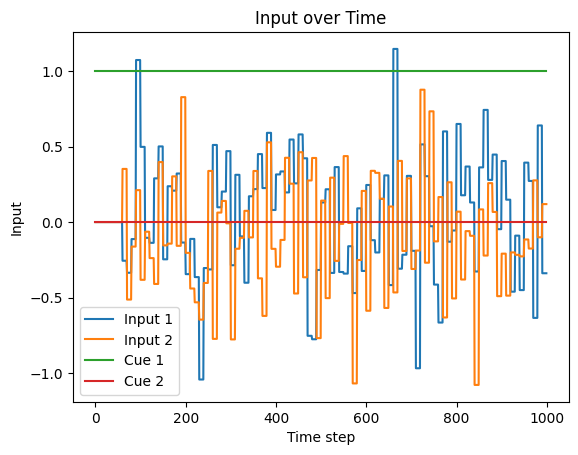

In [19]:
#Examining expected input and output

#4,1000, probably 4 channels, two cues and two inputs
print(f_in.shape)
plt.plot(f_in[0],label="Input 1")
plt.plot(f_in[1],label = "Input 2")
plt.plot(f_in[2],label = "Cue 1")
plt.plot(f_in[3], label = "Cue 2")
#plt.plot(f_out[0],label="Output")
plt.ylabel("Input")
plt.xlabel("Time step")
plt.title("Input over Time")
plt.legend()

#This is all four input channels

As you can see from the above graph Cue 1 is active, so so Input 1 should be integrated as the output of the network. Below shows what the graph would look like if either Input 1 or Input 2 was integrated, as well as the actual output.

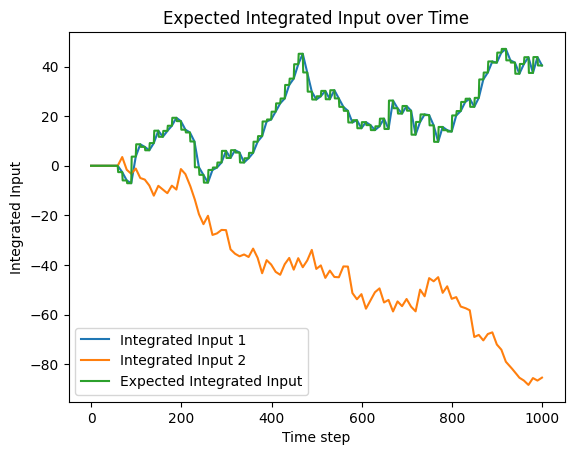

In [20]:
plt.plot(np.cumsum(f_in[0]),label="Integrated Input 1")
plt.plot(np.cumsum(f_in[1]),label="Integrated Input 2")
plt.plot(f_out[0]*10,label="Expected Integrated Input") #For some reason this has to be scaled
plt.ylabel("Integrated Input")
plt.xlabel("Time step")
plt.title("Expected Integrated Input over Time")
plt.legend()


For some reason f_out has to be scaled to match an integrated input

## Actual Network

In [21]:
print(u_in.shape)
print((u_in @ f_in).shape) #First index is for neuron number, second index for is time step.
print(v0.squeeze().shape)

(800, 4)
(800, 1000)
(800,)


In [22]:
N = 800 # Number of neurons in the contextual-integration task
tau = 10 * b2.ms
tau_f = 5 * b2.ms 
tau_s = 100 * b2.ms
#I will be assuming voltage is unitless for ease
v_t = 0 #Voltage Threshold
v_r = -10 #Voltage Reset
J_fac = u @ w
J_s = J0ss + J_fac[:,N:]
J_f = J0fs + J_fac[:,:N]
#I_int = (J_s * s_s + J_f * s_f)
#Let j_s and j_f represent the per neuron values of J_s and J_f.
I_in = u_in @  f_in


steps = 1000

In [35]:
#Assuming left half of j is for s^f
b2.start_scope()
b2.prefs.codegen.target = "cython"
b2.defaultclock.dt = 1 * b2.ms

Input = b2.TimedArray(I_in.T,dt= 1 * b2.ms) #This defines which neuron is which, so order matters
#Must be time first, then neuron
neuron_equation = """ 
dv/dt  = (I_rec + Input(t,i)  + v_u - v)/tau : 1
I_rec : 1
v_u : 1

dsf/dt = -sf/tau_f : 1
dss/dt = -ss/tau_s : 1

"""
Neurons = b2.NeuronGroup(N,model = neuron_equation,threshold="v>=v_t",reset="""
                         v = v_r 
                         ss += 1 
                         sf += 1""",method="euler")
Neurons.v[:] = v0.squeeze() #This follows the proper order
Neurons.v_u[:] = vJsbar.squeeze()
Neurons.ss[:] = ss0.squeeze()
Neurons.sf[:] = sf0.squeeze()
synapse_equation = """ 
j_s : 1
j_f : 1

I_rec_post = j_s * ss_pre + j_f * sf_pre: 1 (summed)
"""
#Is this : 1 necessary if the variables have already been defined in the main synapse equation?

Synapses = b2.Synapses(Neurons,Neurons,model=synapse_equation)
Synapses.connect(True) #Connects every synapse to every other synapse

#I'm not sure if synapses are properly being assigned and stuff

Synapses.j_s[:] = J_s.reshape(-1)
Synapses.j_f[:] = J_f.reshape(-1) 


Monitor = b2.StateMonitor(Neurons,["ss","sf","v"],record=True)
Spikes = b2.SpikeMonitor(Neurons)
b2.run(steps* b2.ms)

WARNING    'sf' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value array([[3.18820206e-23, 2.55056165e-23, 2.04044932e-23, ...,
        2.50000000e+00, 2.50000000e+00, 2.50000000e+00],
       [1.78628471e-31, 1.42902777e-31, 1.14322222e-31, ...,
        2.50000000e+00, 2.50000000e+00, 2.50000000e+00],
       [6.53748667e-30, 5.22998933e-30, 4.18399147e-30, ...,
        2.50000000e+00, 2.50000000e+00, 2.50000000e+00],
       ...,
       [6.43831643e-24, 5.15065315e-24, 4.12052252e-24, ...,
        2.50000000e+00, 2.50000000e+00, 2.50000000e+00],
       [1.13706422e-11, 9.09651378e-12, 7.27721103e-12, ...,
        2.50000000e+00, 2.50000000e+00, 2.50000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.50000000e+00, 2.50000000e+00, 2.50000000e+00]]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'ss' is an internal variable of group 'neurongroup', but al

### Debugging

In [37]:
#Select a few random neurons to see how their voltage is changing
v = Monitor.v
print(v.shape)

(800, 1000)


: 

## Calculating Final Output

In [32]:
# Output = Wws(t)
#ss_squared = Monitor.ss.reshape(N,N,steps)
#sf_squared = Monitor.sf.reshape(N,N,steps)
#ss and sf are repeated across the columns, because they are the same for synapses coming from the same neuron
#ss = ss_squared[:,0]
#sf = sf_squared[:,0]
ss = Monitor.ss.squeeze()
sf = Monitor.sf.squeeze()
s = np.concatenate((sf,ss),axis=0) #sf Should should be first

factors = np.concatenate((w @ s,np.ones((1,steps))),axis=0)
output = (W @ factors).flatten() #Should graph factors.



Text(0, 0.5, 'Factors')

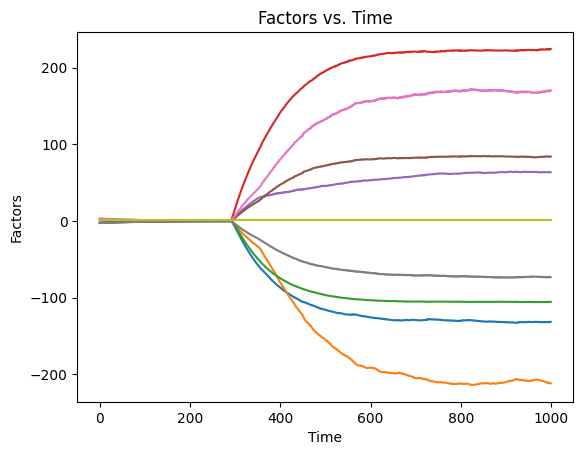

In [33]:
#Grpahing factors
for i in range(factors.shape[0]):
    plt.plot(factors[i])
plt.title("Factors vs. Time")
plt.xlabel("Time")
plt.ylabel("Factors")

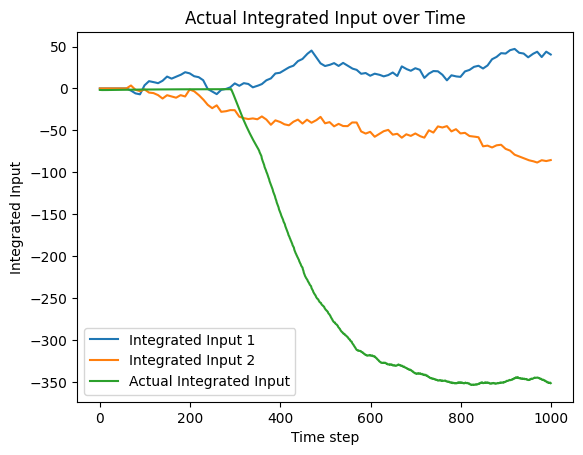

In [34]:
plt.plot(np.cumsum(f_in[0]),label="Integrated Input 1")
plt.plot(np.cumsum(f_in[1]),label="Integrated Input 2")
plt.plot(output,label="Actual Integrated Input")
plt.ylabel("Integrated Input")
plt.xlabel("Time step")
plt.title("Actual Integrated Input over Time")
plt.legend()